In [128]:
import os
import pcse
import yaml
import h5py
import numpy as np
import pandas as pd
import geopandas as gpd
import datetime as dt
from multiprocessing import Pool
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
import seaborn as sns
from pcse.models import Wofost71_PP, Wofost71_WLP_FD
from pcse.base import ParameterProvider
from pcse.db import NASAPowerWeatherDataProvider
from pcse import fileinput as fi
from pcse.util import WOFOST71SiteDataProvider

In [2]:
agro_yaml = """
Version: 1.0
AgroManagement:
- {sim_start_date}:
    CropCalendar:
        crop_name: maize
        variety_name: Maize_VanHeemst_1988
        crop_start_type: sowing
        crop_start_date: {crop_start_date}
        crop_end_type: earliest
        crop_end_date: {crop_end_date}
        max_duration: 300
    TimedEvents: 
    -   event_signal: apply_n
        name:  Nitrogen application table
        comment: All nitrogen amounts in g N m-2
        events_table:
        - {fert_date}: {{amount: {n_rate}, recovery: 0.7}}
    StateEvents: null
"""

In [3]:
soildata = {'SMFCF': 0.2, 'SMW': 0.1, 'CRAIRC': 0.1, 'KSUB': 20.0,
            'RDMSOL': 200.0, 'K0': 100.0, 'SOPE': 10.0, 'SM0': 0.4}

cropdata = fi.YAMLCropDataProvider()
cropdata.set_active_crop('maize', 'Maize_VanHeemst_1988')

sitedata = WOFOST71SiteDataProvider(WAV=100, CO2=400)

parameters = ParameterProvider(cropdata=cropdata, soildata=soildata, sitedata=sitedata)

In [4]:
def run(wfile):
    site = os.path.basename(wfile).replace('.csv', '')
    wdp = fi.CSVWeatherDataProvider(wfile)

    # get new start date
    crop_start_date = pd.to_datetime(site[18:26], format='%Y%m%d').date()
    sim_start_date = crop_start_date - dt.timedelta(days = 90)
    crop_end_date = crop_start_date + dt.timedelta(days = 210)
    fert_date = crop_start_date + dt.timedelta(days = 30)
    n_rate = 100

    # update agromanagement with new start date and load it with yaml.load
    tmp = agro_yaml.format(sim_start_date = sim_start_date,
                           crop_start_date = crop_start_date,
                           crop_end_date = crop_end_date,
                           fert_date = fert_date,
                           n_rate = n_rate)
    agromanagement = yaml.load(tmp, yaml.FullLoader)

    wofsim = Wofost71_WLP_FD(parameters, wdp, agromanagement)
    wofsim.run_till_terminate()
    output = wofsim.get_output()
    df = pd.DataFrame(output).set_index("day")
    df['SIM'] = site
    df['SIM_DATE'] = crop_start_date
    return(df.iloc[-1])


In [84]:
wdir = '/home/rodrigo7/Apsim_test/MASAGRO/DAYMET_TILE'

train_methods = ['none', 'rnd', 'adv']
wfiles = sorted(os.listdir(wdir))
wfiles_l = []
for train_method in train_methods:
    for train_pct in [1,5]:
        [wfiles_l.append(os.path.join(wdir, f)) for f in wfiles if f.endswith(f'_opt_{train_method}_0{train_pct}.csv')]
wfiles = wfiles_l
print(len(wfiles_l))

19200


In [80]:
w = pd.read_csv(wfiles[0], skiprows = 13)
# w

In [81]:
df_test = run(wfiles[0])

In [82]:
output = []
if __name__ == '__main__':
    with Pool(processes=30) as p:
        with tqdm(total=len(wfiles)) as pbar:
            for i, df in enumerate(p.imap_unordered(run, wfiles)):
                output.append(df)
                pbar.update()

output_df = pd.DataFrame(output)
output_df.to_hdf('../data/PSCE_TILE_adv.h5', key = 'SIM')

/opt/anaconda3/envs/GEOANN/lib/python3.7/site-packages/pandas/core/generic.py:2504: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['SIM', 'SIM_DATE'], dtype='object')]

  encoding=encoding,


In [112]:
output_df = pd.read_hdf('../data/PSCE_TILE_adv.h5', key = 'SIM')
output_df = output_df.sort_values('SIM')

In [120]:
yy = []
for train_method in train_methods:
    for train_pct in [1,5]:
        yp = np.load(f'../data/y_pred_opt_{train_method}_0{train_pct}.npy')
        ydf = pd.DataFrame(yp, columns=['Yield0', 'Yield_adv'])
        ydf['train_method'] = train_method
        ydf['train_pct'] = train_pct
        ydf['id'] = np.arange(len(ydf))
        yy.append(ydf)
yy = pd.concat(yy)
yy = yy.sort_values(['id', 'train_method', 'train_pct'])
yy['SIM'] = output_df.SIM.values
yy['Yield'] = output_df.TWSO.values

In [126]:
yy

,Yield0,Yield_adv,train_method,train_pct,id,SIM,Yield
0,6988.320312,9087.945312,adv,1,0,DAYMET_9584_00_00_20170704_opt_adv_01,7779.979121
0,6297.435059,9494.258789,adv,5,0,DAYMET_9584_00_00_20170704_opt_adv_05,9615.435975
0,6420.588867,11116.359375,none,1,0,DAYMET_9584_00_00_20170704_opt_none_01,9449.597924
0,6171.237305,9930.173828,none,5,0,DAYMET_9584_00_00_20170704_opt_none_05,9386.325815
0,6846.861328,9500.494141,rnd,1,0,DAYMET_9584_00_00_20170704_opt_rnd_01,9687.590529
...,...,...,...,...,...,...,...
3199,7700.784668,10546.403320,adv,5,3199,DAYMET_9584_39_39_20180704_opt_adv_05,10914.304303
3199,8062.473145,11308.352539,none,1,3199,DAYMET_9584_39_39_20180704_opt_none_01,10927.729978
3199,1624.578247,11120.076172,none,5,3199,DAYMET_9584_39_39_20180704_opt_none_05,10278.036233
3199,8004.220215,10731.423828,rnd,1,3199,DAYMET_9584_39_39_20180704_opt_rnd_01,11540.283338


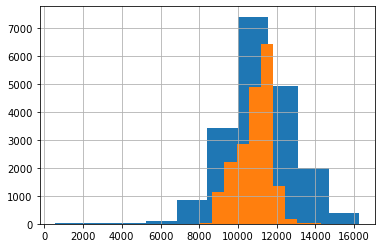

In [124]:
yy.Yield.hist()
yy.Yield_adv.hist()

In [143]:
yy['Yield_diff'] = yy.Yield - yy.Yield_adv

In [148]:
yy.groupby('train_method').Yield_diff.mean()

train_method
adv     677.980177
none    -76.111379
rnd     135.613846
Name: Yield_diff, dtype: float64

In [149]:
from sklearn.metrics import r2_score, mean_squared_error

In [155]:
def rmse( g ):
    rmse = np.sqrt( mean_squared_error( g['Yield'], g['Yield_adv'] ) )
    return pd.Series( dict( rmse = rmse ) )

yy.groupby(['train_method', 'train_pct']).apply( rmse ).reset_index()

,train_method,train_pct,rmse
0,adv,1,2102.841061
1,adv,5,1684.872721
2,none,1,1422.187778
3,none,5,1732.211374
4,rnd,1,1845.501165
5,rnd,5,2183.502464


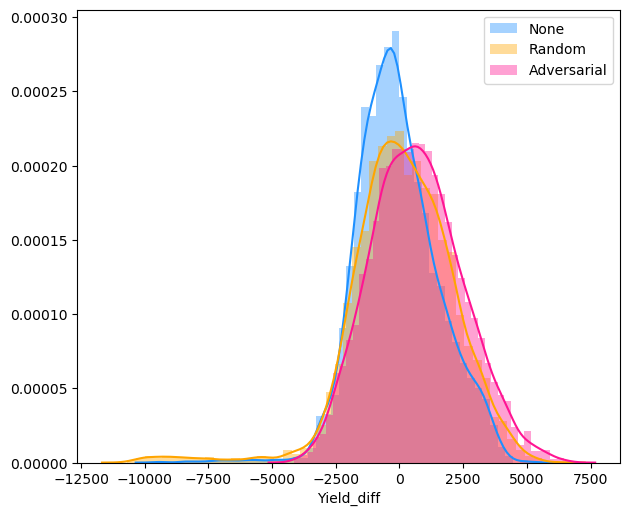

In [144]:
plt.subplots(figsize=(7,6), dpi=100)
sns.distplot( yy.loc[yy.train_method=='none', "Yield_diff"] , color="dodgerblue", label="None")
sns.distplot( yy.loc[yy.train_method=='rnd', "Yield_diff"] , color="orange", label="Random")
sns.distplot( yy.loc[yy.train_method=='adv', "Yield_diff"] , color="deeppink", label="Adversarial")

plt.legend()

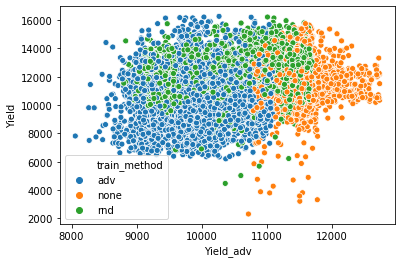

In [139]:
sns.scatterplot('Yield_adv', 'Yield', 'train_method', data = yy.loc[yy.train_pct == 1])

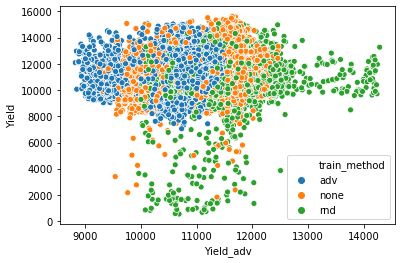

In [140]:
sns.scatterplot('Yield_adv', 'Yield', 'train_method', data = yy.loc[yy.train_pct == 5])